##  📊 DATA LOADING

In [1]:
import tensorflow as tf

2025-06-29 06:28:32.616169: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-29 06:28:32.725067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751174912.791550   38891 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751174912.809763   38891 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751174912.960851   38891 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

root = "./"

In [ ]:
data_dir = f"{root}/merged_dataset/"
batch_size = 32
img_height = 224
img_width  = 224
validation_split = 0.2
seed = 123

# ----- Loading data from the directory into training and validation sets ----- #
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

class_names = train_ds.class_names
print("\nClass names:", class_names)

Found 7675 files belonging to 3 classes.
Using 6140 files for training.
Found 7675 files belonging to 3 classes.
Using 1535 files for validation.

Class names: ['type1', 'type2', 'type3']


## ✍️ DATA PREPROCESSING

In [4]:
from tensorflow.keras import layers, models # type: ignore
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# ----- Function to convert images in a dataset to grayscale ----- #
def to_grayscale(image, label):
    # Convert RGB to Grayscale
    image = tf.image.rgb_to_grayscale(image)  # [H, W, 1]
    image = tf.cast(image, tf.uint8)

    # Convert back to 3 channels by duplicating the grayscale channel
    image = tf.image.grayscale_to_rgb(image)  # [H, W, 3]
    return image, label

# ----- Converting images to grayscale ----- #
# train_ds = train_ds.map(to_grayscale)
# val_ds = val_ds.map(to_grayscale)

In [15]:
# ----- Creating a test set from the validation set ----- #
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 39
Number of test batches: 9


In [9]:
# ----- Defining the image augmentation pipeline ----- #
# data_augmentation = models.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.RandomContrast(0.2),
# ])

In [7]:
# Getting samples for each shape
cnames = ["type1", "type2", "type3"]
class_images = {cat: [] for cat in cnames}

for image, label in train_ds.unbatch():
    cat = cnames[np.argmax(label.numpy())]
    # Take 5 samples images per class
    if len(class_images[cat]) < 5:
        class_images[cat].append(image.numpy())
    if all(len(images) >= 5 for images in class_images.values()):
        break

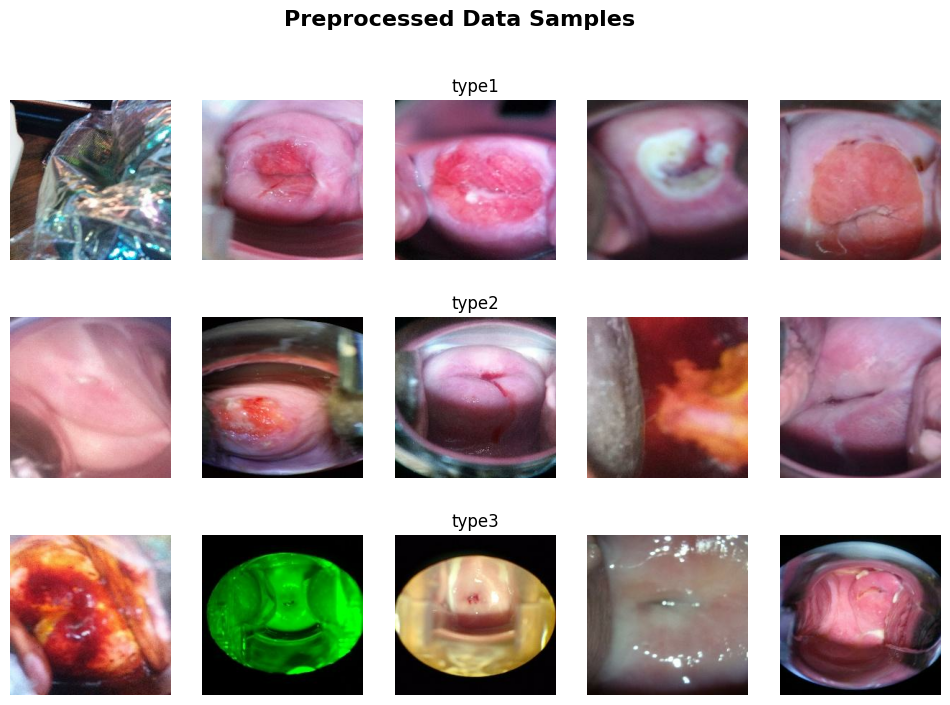

In [8]:
fig, axes = plt.subplots(len(cnames), 5, figsize=(12, 8))

for i, cat in enumerate(cnames):
    for j in range(5):
        if j < len(class_images[cat]):
            ax = axes[i, j]
            ax.imshow(class_images[cat][j] / 255.) # /255. to normalize RGB values of image
            # Turn off ticks for better display (remove axis numbers)
            ax.axis("off")
            # Placing category name at middle image
            if j == 2:
                ax.set_title(cat)
# plt.tight_layout()
plt.suptitle("Preprocessed Data Samples", fontsize=16, fontweight="bold")
plt.savefig(f"{root}/plots/data_samples.png")
plt.show()

## 🤖 Model Creation

In [9]:
from tensorflow.keras import models, callbacks, layers, optimizers  #type:ignore
from tensorflow.keras import applications  # type: ignore
# from tensorflow.keras.applications.efficientnet import preprocess_input  # type: ignore
from tensorflow.keras.applications.resnet_v2 import preprocess_input  # type: ignore

In [13]:
# ----- Creating the base model (EfficientNetB2) ----- #
base_model = applications.ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# Freeze the training of the base model layers
base_model.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 247s 3us/step


In [14]:
# ----- Creating the full model architecture ----- #
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
# x = layers.Dense(512, activation="relu")(x)
# x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# ----- Creating callbacks for the model training ----- #

# -> Callback to save best model during training
checkpoint_cb = callbacks.ModelCheckpoint(
    f"{root}/models/cervical_cancer_classifier.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)

# -> Callback for stopping the model when there is no imporovement
earlystop_cb = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# -> Callback to adjust learning rate if there is no improvement
reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-8
)

callbacks_list = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

## 🥋 Model Training

### ⛳ TRAINING PHASE ONE: HEAD ONLY

In [16]:
# ----- Compiling the model for first training phase ----- #
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,666,051 (97.91 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [17]:
# ---- Training the classification head only ----- #
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks_list
)

Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 157s 802ms/step - accuracy: 0.5334 - loss: 1.2708 - val_accuracy: 0.6063 - val_loss: 0.8289 - learning_rate: 0.0010
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 153s 796ms/step - accuracy: 0.6092 - loss: 0.8141 - val_accuracy: 0.6311 - val_loss: 0.8089 - learning_rate: 0.0010
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 156s 812ms/step - accuracy: 0.6678 - loss: 0.7527 - val_accuracy: 0.6215 - val_loss: 0.7864 - learning_rate: 0.0010
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 155s 807ms/step - accuracy: 0.6887 - loss: 0.6914 - val_accuracy: 0.6199 - val_loss: 0.7846 - learning_rate: 0.0010
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 152s 793ms/step - accuracy: 0.7193 - loss: 0.6446 - val_accuracy: 0.6279 - val_loss: 0.7817 - learning_rate: 0.0010


### 📌 TRAINING PHASE TWO: FINETUNING

In [18]:
# tf.keras.backend.clear_session(free_memory=True)

In [19]:
# ----- Finetuning model layers ----- #
base_model.trainable = True

# Leave only batch normalization layers frozen
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# ----- Compiling the model for second training phase ----- #
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,666,051 (97.91 MB)

 Trainable params: 25,575,171 (97.56 MB)

 Non-trainable params: 90,880 (355.00 KB)

In [20]:
# ----- Initiating second training phase ----- #
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks_list
)

Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 528s 3s/step - accuracy: 0.7517 - loss: 0.5775 - val_accuracy: 0.6792 - val_loss: 0.7045 - learning_rate: 1.0000e-05
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.8602 - loss: 0.3729 - val_accuracy: 0.6792 - val_loss: 0.7091 - learning_rate: 1.0000e-05
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.9102 - loss: 0.2549 - val_accuracy: 0.7025 - val_loss: 0.7486 - learning_rate: 1.0000e-05
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9502 - loss: 0.1477

2025-06-12 07:46:49.414040: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267968 bytes after encountering the first element of size 19267968 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


192/192 ━━━━━━━━━━━━━━━━━━━━ 532s 3s/step - accuracy: 0.9503 - loss: 0.1476 - val_accuracy: 0.7065 - val_loss: 0.8693 - learning_rate: 1.0000e-05
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.9779 - loss: 0.0820 - val_accuracy: 0.7153 - val_loss: 0.9549 - learning_rate: 5.0000e-06
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.9901 - loss: 0.0475 - val_accuracy: 0.7073 - val_loss: 1.0148 - learning_rate: 5.0000e-06


## 📝 Model Evaluation

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import random

In [11]:
# ----- Helper function to plot training curves ----- #
def plot_training_curves(
    history: dict,
    save_filename: str,
    title: str = "Model Training Performance",
) -> None:
    history = history2.history
    plt.figure(figsize=(15, 5), dpi=100)

    # ----- Plot training and validation accuracy values ----- #
    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Training Accuracy", c="red")
    plt.plot(history["val_accuracy"], label="Validation Accuracy", c="green")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="lower right")

    # ----- Plot training and validation loss values ----- #
    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Training Loss", c="red")
    plt.plot(history["val_loss"], label="Validation Loss", c="green")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="upper right")
    plt.suptitle(title, fontsize=16, fontweight="bold")

    plt.tight_layout()
    plt.grid(True)
    plt.savefig(f"{root}/plots/{save_filename}.png")
    plt.show()

# ----- Helper functions to plot confusion matrix and classification report ----- #
def predict_cats(model, dataset) -> dict:
    prediction = {}
    # Getting the true values
    true_vals = np.concatenate([label.numpy() for img, label in dataset], axis=0)
    true_vals = np.argmax(true_vals, axis=-1)
    # Add true values to the dictionary
    prediction["true"] = true_vals
    # Probability of classes
    pred_prob = model.predict(dataset)
    # Getting the predicted values
    pred_vals = np.argmax(pred_prob, axis=-1)
    # Add predicted values to the dictionary
    prediction["pred"] = pred_vals

    return prediction

def show_evaluation_report(model, dataset: list, filename: str, matrix_title: str) -> None:
    colors = ["crest", "coolwarm", "Spectral", "flare", "Set1", "Set2", "Set3"]
    # Dictionary of true and predicted values from the dataset
    for _set in dataset:
        try:
          class_names = _set.class_names
        except AttributeError:
          class_names = ["type1", "type2", "type3"]

        prediction = predict_cats(model=model, dataset=_set)
        # accuracy = accuracy_score(prediction["true"], prediction["pred"])
        plt.figure(figsize=(10, 7))
        # Confusion matrix
        ax = sns.heatmap(
            confusion_matrix(prediction["true"],prediction["pred"]),
            annot=True,
            xticklabels=class_names,
            yticklabels=class_names,
            cmap=random.choice(colors)
        )
        ax.set_title(matrix_title)

        plt.savefig("{}/plots/{}.png".format(root, filename))
        plt.show()

        print("\n\nClassification Report:\n")
        print(classification_report(prediction["true"], prediction["pred"], target_names=class_names))

        # print("\n\nModel Accuracy: {:.2f}".format(accuracy))

In [23]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 822ms/step - accuracy: 0.6929 - loss: 0.7587

Test Accuracy: 0.7014


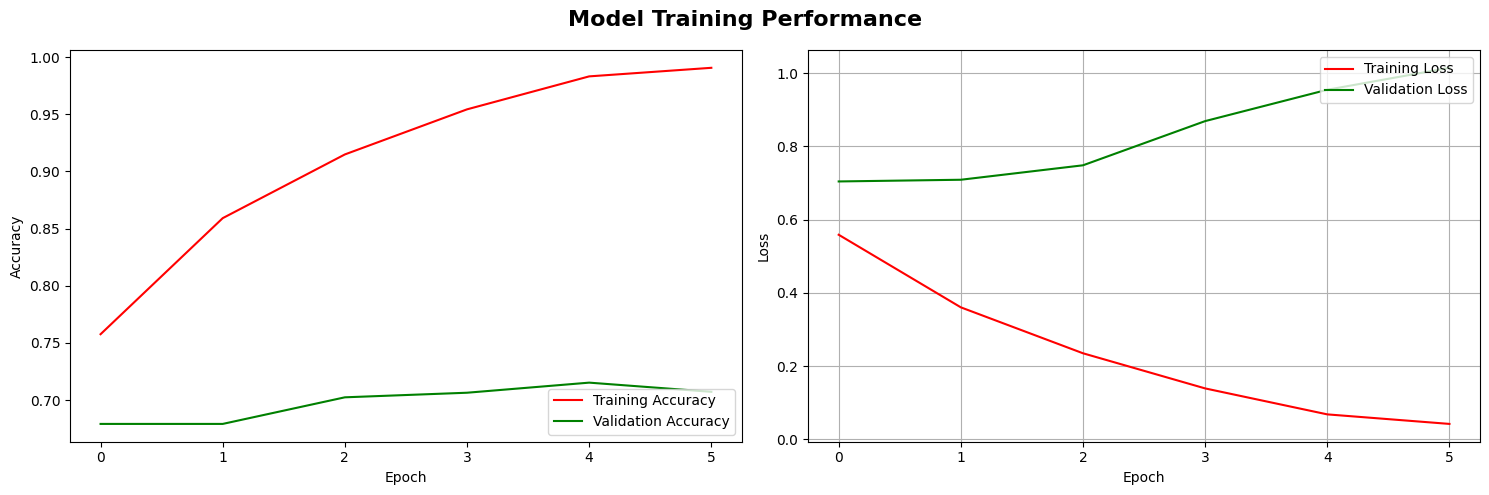

In [24]:
plot_training_curves(history1, "phase_one_training_curves")

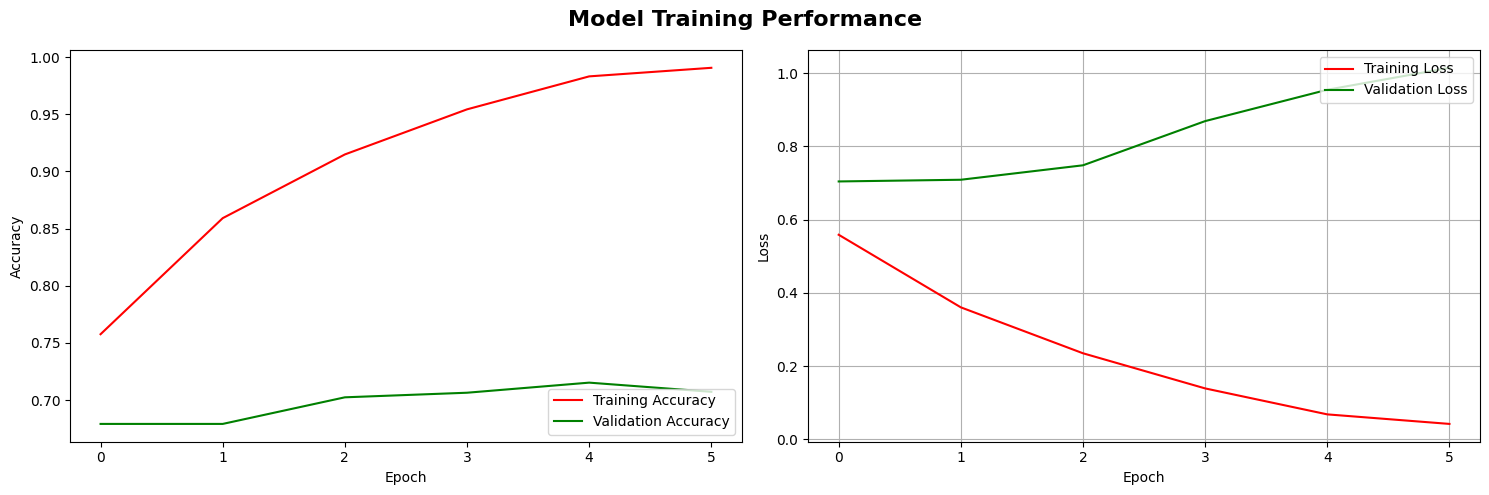

In [25]:
plot_training_curves(history2, "phase_two_training_curves")

In [12]:
# Loading saved model
model = tf.keras.models.load_model(f"{root}/models/cervical_cancer_classifier2.keras")

192/192 ━━━━━━━━━━━━━━━━━━━━ 146s 759ms/step


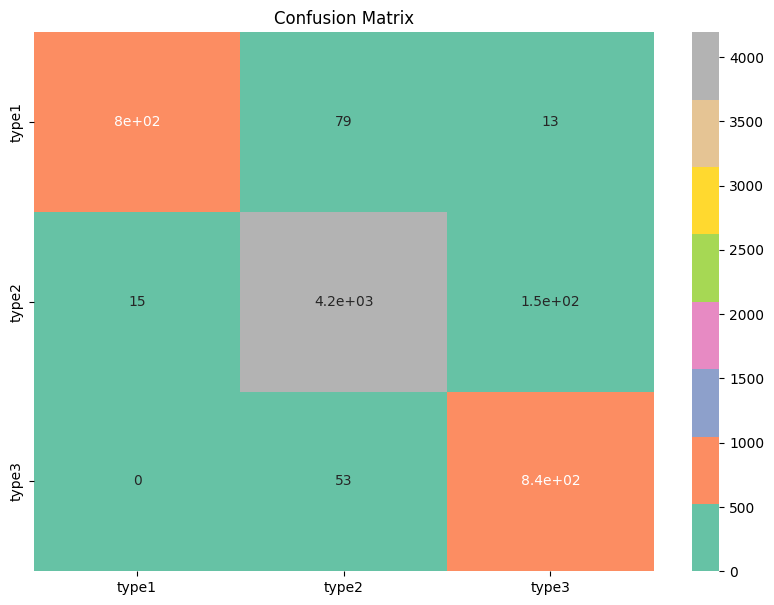



Classification Report:

              precision    recall  f1-score   support

       type1       0.98      0.90      0.94       893
       type2       0.97      0.96      0.97      4356
       type3       0.84      0.94      0.89       891

    accuracy                           0.95      6140
   macro avg       0.93      0.93      0.93      6140
weighted avg       0.95      0.95      0.95      6140



In [ ]:
show_evaluation_report(model, [test_ds], "confusion_matrix", "Confusion Matrix")